# A small fine-tuning experiment with OpenAI

In [80]:
TRAIN_PATH='/tmp/finetuning_train.jsonl'
TEST_PATH='/tmp/finetuning_test.jsonl'

## Install somme packages

In [1]:
!pip install python-dotenv numpy pandas matplotlib huggingface_hub datasets openai tiktoken

Looking in indexes: https://pypi.org/simple, https://****@pypi.fury.io/sarus/


## Generate input files

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from datasets import load_dataset

dataset = load_dataset("LeoTungAnh/electricity_hourly")

In [4]:
dataset['train']

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 370
})

In [5]:
# import os
# from huggingface_hub import login

# login(os.getenv("HF_TOKEN"))
# dataset = load_dataset("EDS-lab/electricity-demand", "demand")

In [6]:
from json import dumps

def format(series):
    return dumps({"messages": [
        {"role": "system", "content": "Given a meter ID, you return a series of hourly consumptions given as a json string."},
        {"role": "user", "content": dumps({'item_id': series['item_id']})},
        {"role": "assistant", "content": dumps({'consumption': [round(1000*x)/1000 for x in series['target'][:100]]})}
    ]})+"\n"

with open(TRAIN_PATH, 'w') as f:
    for series in dataset['train']:
        f.write(format(series))

with open(TEST_PATH, 'w') as f:
    for series in dataset['test']:
        f.write(format(series))

NameError: name 'TRAIN_PATH' is not defined

## Validate the data

In [ ]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

In [ ]:
data_path = TRAIN_PATH

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 370
First example:
{'role': 'system', 'content': 'Given a meter ID, you return a series of hourly consumptions given as a json string.'}
{'role': 'user', 'content': '{"item_id": "MT_001"}'}
{'role': 'assistant', 'content': '{"consumption": [-0.194, -0.089, -0.194, -0.089, -0.141, -0.141, -0.089, -0.194, -0.456, -0.036, 1.751, 0.7, 0.122, -0.562, 0.7, 1.068, -0.509, 1.015, 1.699, -0.194, 0.437, 2.172, 1.12, 0.7, -0.246, -0.194, -0.246, -0.194, -0.246, -0.299, -0.351, -0.351, 1.383, 1.909, 1.856, 2.434, 2.382, 1.699, 2.645, 1.856, 2.855, 0.647, 1.12, -0.246, 0.858, 0.963, 0.279, 0.91, -0.194, -0.246, -0.194, -0.246, -0.351, -0.299, -0.299, 0.174, 1.856, 1.804, 1.699, 2.014, 2.014, 0.7, 1.015, 2.014, 2.96, -0.036, 2.224, 0.332, 0.858, 2.066, 0.858, 1.331, -0.089, -0.036, -0.141, -0.089, -0.141, -0.194, -0.194, 0.174, 1.751, 2.224, 2.54, 2.172, 1.856, 2.277, 0.437, 0.332, 1.751, 3.328, 2.277, 0.174, 0.069, 2.277, 0.647, 0.91, 0.91, 0.91, 0.752, 2.066]}'}


In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")



Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 547, 547
mean / median: 547.0, 547.0
p5 / p95: 547.0, 547.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 504, 504
mean / median: 504.0, 504.0
p5 / p95: 504.0, 504.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~202390 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~607170 tokens


## Finetune

In [7]:
from openai import OpenAI

client = OpenAI()

def upload_files():
  with open(TRAIN_PATH, "rb") as f:
    client.files.create(file=f, purpose="fine-tune")

  with open(TEST_PATH, "rb") as f:
    client.files.create(file=f, purpose="fine-tune")


# upload_files()

In [ ]:
# client.fine_tuning.jobs.create(
#   training_file=TRAIN_PATH,
#   validation_file=TEST_PATH,
#   model="gpt-3.5-turbo"
# )

0
1
2
3
4
5
6
7
8
9
10


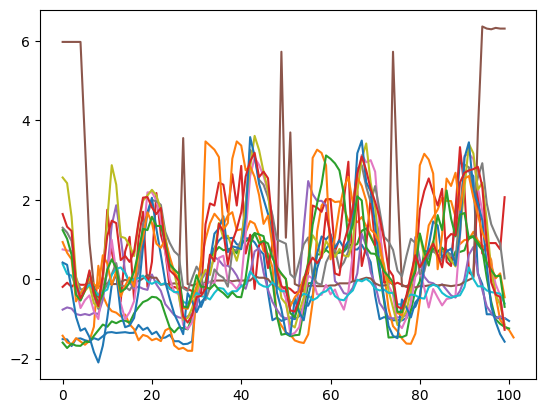

In [10]:
import matplotlib.pyplot as plt
import json

data = [-1.511, -1.517, -1.685, -1.504, -1.492, -1.538, -1.567, -1.485, -1.526, -1.438, -1.344, -1.333, -1.355, -1.345, -1.335, -1.355, -1.35, -1.153, -1.278, -1.22, -1.386, -1.323, -1.487, -1.47, -1.402, -1.563, -1.562, -1.638, -1.627, -1.567, -0.318, -0.699, -0.425, 0.505, 0.792, 0.975, 1.081, 1.029, 1.041, 0.881, 0.851, 1.03, 1.029, 0.927, 0.747, 0.632, -0.337, -1.034, -0.967, -1.051, -1.006, -0.977, -1.006, -0.932, -0.661, -0.667, -0.408, 0.275, 0.632, 0.767, 0.911, 0.632, 0.671, 0.692, 0.828, 0.747, 0.749, 0.871, 0.663, 0.428, -0.42, -1.009, -0.956, -0.985, -1.038, -1.027, -1.038, -0.984, -0.762, -0.694, -0.425, 0.31, 0.566, 0.756, 0.687, 0.759, 0.743, 0.433, 1.567, 3.019, 2.736, 2.722, 2.598, 0.135, -0.126, -0.884, -0.884, -0.945, -1.002, -0.979, -1.053]
plt.plot(data)
data = [-1.424, -1.592, -1.645, -1.486, -1.57, -1.652, -1.554, -1.199, 0.338, -0.415, -0.667, -0.805, -0.843, -0.937, -0.89, -1.137, -1.259, -1.538, -1.404, -1.44, -1.538, -1.496, -1.56, -1.289, -1.23, -1.669, -1.76, -1.729, -1.804, -1.805, -0.239, 0.477, 1.001, 1.41, 1.649, 1.511, 1.378, 1.603, 1.688, 1.232, 1.259, 1.179, 1.464, 1.399, 1.111, 0.717, 0.644, 0.299, -0.973, -1.169, -1.344, -1.398, -1.543, -1.585, -1.608, -1.39, -0.575, 1.2, 1.857, 2.011, 2.021, 1.944, 1.959, 1.79, 1.47, 1.512, 1.436, 1.567, 1.341, 1.093, 0.831, 0.516, 0.161, -0.734, -1.182, -1.311, -1.496, -1.622, -1.628, -1.375, -0.56, 0.578, 1.357, 1.562, 1.753, 2.055, 1.974, 1.968, 1.572, 0.885, 0.987, 1.002, 1.193, 0.978, 0.849, 0.746, 0.484, -0.424, -1.026, -1.19, -1.282, -1.468]
plt.plot(data)
data = [-1.598, -1.734, -1.625, -1.674, -1.68, -1.574, -1.583, -1.427, -1.285, -1.143, -1.198, -1.063, -1.109, -1.051, -1.044, -1.098, -0.862, -0.708, -0.576, -0.529, -0.444, -0.459, -0.552, -0.893, -1.218, -1.34, -1.217, -1.234, -1.263, -0.953, -0.202, -0.151, -0.078, 0.545, 0.667, 0.811, 0.73, 0.753, 0.784, 0.652, 0.956, 0.956, 1.04, 1.16, 1.127, 1.085, 0.553, -0.044, -0.932, -1.4, -1.375, -1.437, -1.412, -1.401, -0.778, -0.103, -0.094, 0.625, 0.625, 0.736, 0.642, 0.661, 0.674, 0.716, 0.878, 0.843, 0.887, 1.22, 1.28, 1.058, 0.841, 0.133, -0.559, -1.47, -1.462, -1.443, -1.462, -1.413, -0.79, -0.293, -0.057, 0.709, 0.695, 0.768, 0.691, 0.796, 0.578, 0.409, 0.699, 0.687, 0.726, 1.057, 1.087, 0.924, 0.761, 0.034, -0.568, -1.01, -1.126, -1.204, -1.242]
plt.plot(data)

for i, series in enumerate(dataset['train']):
    if i>10:
        break
    print(i)
    plt.plot(series['target'][:100])
    